In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.visualization import visualize_clusters

In this week's exercise we will be using the clustering methods k-Means and DBSCAN. First, the simplicity of implementing k-Means is shown, then different initialization techniques are compared and finally DBSCAN is applied on the data.

## 1 The k-Means algorithm

To get a grip on k-Means, you might implement two parts of the algorithm:

**_update_clusters**
- As parameters, the function gets a DataFrame ($n \times d$) containing the dataset and a DataFrame/matrix ($k \times d$) containing the $k$ means
- It returns an array of length $n$, containing a cluster label for each sample (row) of the data set 

**_update_means**
- This gets the DataFrame ($n \times d$) containing the dataset as well as an array of length $n$ containing the cluster label of each sample as parameters
- It returns a DataFrame/matrix of size $k \times d$ containing $k$ updated means 

<br>
Some Hints:
- https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.spatial.distance.cdist.html
- https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.argmin.html
- https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html

Feel free to add import statements! 

In [65]:
# Implement _update_clusters and _update_means

def myKMeans(data, k, iterations):
    means = _init_means(data, k)
    clusters = _update_clusters(data, means)

    for i in range(iterations):
        means = _update_means(data, clusters, means)
        clusters = _update_clusters(data, means)

    return clusters


def _init_means(data, k):
    min_values = data.min()
    max_values = data.max()
    means = np.random.uniform(min_values, max_values, (k, data.shape[1]))
    return means


def _update_clusters(data, means):
    distances = np.sqrt(((data - means[:, np.newaxis])**2).sum(axis=2))
    closest_cluster = np.argmin(distances, axis=0)
    return closest_cluster


def _update_means(data, closest, means):
    update = np.array([data[closest==k].mean(axis=0) for k in range(means.shape[0])])
    return update


In [66]:
data = pd.read_csv('data/fifa1.csv')
fts = ['Interceptions', 'Long shots']
test = data[fts].values
k = 2
iterations = 2

cluster = myKMeans(test, k, iterations)
data["Cluster"] = cluster

Test your implementation by clustering the features 'Interceptions' and 'Long shots'. <br>
Try different values for $k$ and visualize the results, using the provided function *visualize_clusters()*. Which $k$ seems to produce the best result? Also calculate the Silhouette Coefficient (http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Does it confirm your intuition?

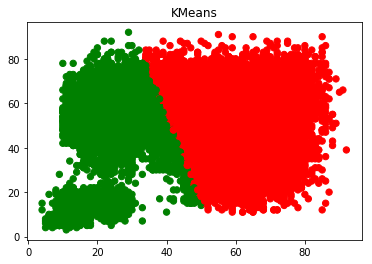

Silhouette Coefficient: 0.422


In [67]:
# Use your k-Means implementation and visualize the results. Print the silhouette score.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import metrics

data = pd.read_csv('data/fifa1.csv')
fts = ['Interceptions', 'Long shots']
test = data[fts].values
k = 2
iterations = 5

cluster = myKMeans(test, k, iterations)
data["Cluster"] = cluster

colors = np.array(['red','green'])
plt.scatter(test[:,0], test[:,1],c=colors[data['Cluster']], s=40)
plt.title('KMeans')
plt.show()

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(test, cluster,metric='euclidean'))

## 2 Different initializations of k-Means

Take a look at the influence of different initializations of the k-Means algorithm. For this, compare random initialization with the '*k-means++*' initialization (https://en.wikipedia.org/wiki/K-means%2B%2B). Use the sklearn implementation of k-Means <br>(http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and run the algorithm with: 
- 1, 2, 3, 4, 5, 10, 20 as the maximum number of iterations (*max_iter*)
- 10 initializations each (*n_init*)
- and a convergence tolerance of 0 (*tol*).

For both initialization methods, plot the final value of the objective function (*inertia_*) against the number of iterations in line plots of different colors.

What do you observe?

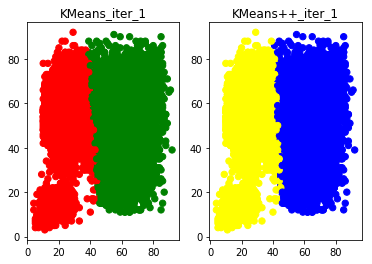

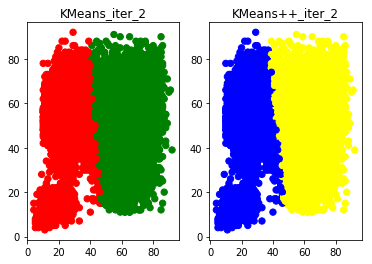

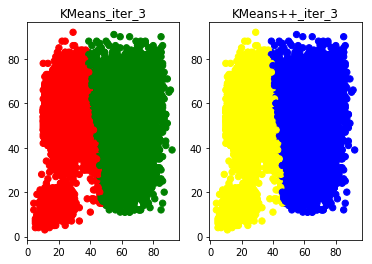

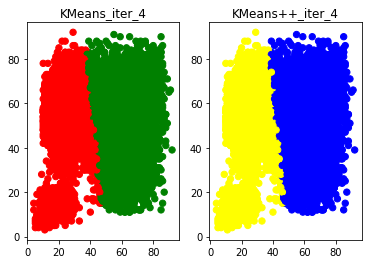

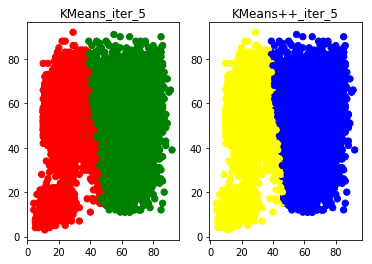

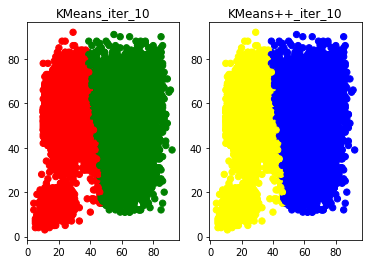

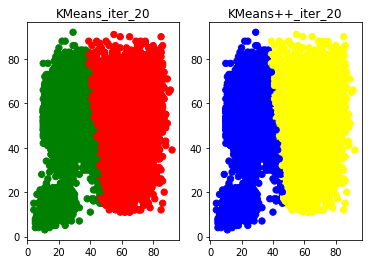

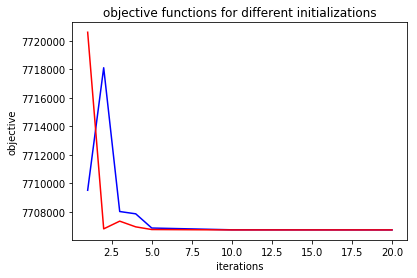

In [49]:
# Use the sklearn implementation of k-Means and plot the objective function for both initialization methods.
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

iterations = [1, 2, 3, 4, 5, 10, 20]

data1 = pd.read_csv('data/fifa1.csv')
fts = ['Interceptions', 'Long shots']
test1 = data1[fts].values

data = pd.read_csv('data/fifa1.csv')
fts = ['Interceptions', 'Long shots']
test = data[fts].values

inertia = []
inertia1 = []
for i in iterations:
    kmeans = KMeans(n_clusters=2, n_init = 10, max_iter=i,tol=0).fit(test)
    kmeans1 = KMeans(n_clusters=2, init='k-means++', n_init = 10, max_iter=i,tol=0).fit(test)
    data["Cluster"]= kmeans.labels_
    data1["Cluster"] = kmeans1.labels_
    inertia= np.append(inertia,kmeans.inertia_)
    inertia1= np.append(inertia1,kmeans1.inertia_)
    colors = np.array(['red','green'])
    colors1 = np.array(['blue','yellow'])
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.scatter(test[:,0], test[:,1],c=colors[data['Cluster']], s=40)
    ax1.set_title("KMeans_iter_{0}".format(i))
    ax2.scatter(test1[:,0], test1[:,1],c=colors1[data1['Cluster']], s=40)
    ax2.set_title("KMeans++_iter_{0}".format(i))
    plt.show()

objective = pd.Series(inertia, index=iterations)
objective_pp = pd.Series(inertia1, index=iterations)

plt.plot(objective.index, objective1, 'b-', label="KMeans")
plt.plot(objective_pp.index, objective_pp, 'r-', label="KMeans++")
plt.title('objective functions for different initializations')
plt.xlabel('iterations')
plt.ylabel('objective')
plt.show()

## 3 Density based clustering: DBSCAN

Finally we compare the results of k-Means, as a distance based clustering with the results of DBSCAN as a density based clustering method. Again we use the features 'Interceptions' and 'Long shots'. 

To do so, estimate a suitable value for $\epsilon$.
Set *MinPts=30* (necessary because the data is relativaly dense and low dimensional) and use a k-distance plot for estimating a proper range for $\epsilon$. For creating this plot, we propose the following steps:
- use the *kneighbors_graph()* function of sklearn for getting the distance of each point to its $k$ (*MinPts*) neighbors <br>
(http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html)
- convert the result to a 2d array (*.toarray()*)
- get the maximum of each row
- sort these values and create the plot

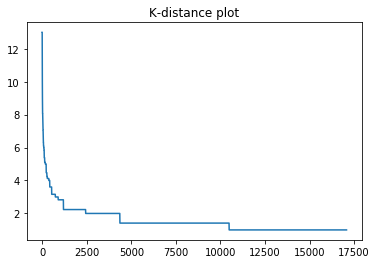

In [80]:
# Follow the suggested steps to plot a k-distance plot. 

from sklearn.neighbors import kneighbors_graph

data = pd.read_csv('data/fifa1.csv')
fts = ['Interceptions', 'Long shots']
test = data[fts].values

A = kneighbors_graph(test, 30, mode ='distance')
B = A.toarray()
maxB = np.amax(B, axis=1)
BB = sorted(maxB, reverse=True)
plt.plot(BB)
plt.title("K-distance plot")
plt.show()

Use the estimated parameter range for DBSCAN (http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). Again, visualize the result by using *visualize_clusters()*. Adjust the parameters to get better results and create one plot with and one without the detected noise (it has cluster label < 0).

In [121]:
# Run DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=2, min_samples=30).fit(test)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

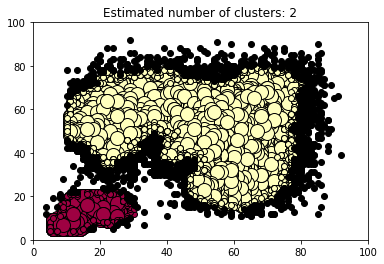

In [122]:
# Visualization with noise
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = test[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)
    
    xy = test[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()

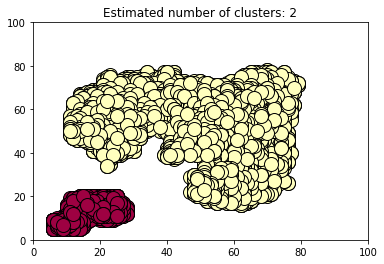

In [123]:
# Visualization without noise
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = test[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()

----

Afterwards: *Nicely done!* :)

And (if you want) an extra: Can you find other clusters in the data? Which dimensions could be used?